In [ ]:
#hide

%load_ext autoreload
%autoreload 2

# Welcome to nangs

> Solving Partial Differential Equations with Neural Networks.

Nangs is a Python library built on top of Pytorch to solve Partial Differential Equations.

Our objective is to develop a new tool for simulating nature, using Neural Networks as solution approximation to Partial Differential Equations, increasing accuracy and optimziation speed while reducing computational cost.

Read our [paper](https://arxiv.org/abs/1912.04737) to know more.

Read the [docs](https://juansensio.github.io/nangs/).

## Installing

nangs is on PyPI so you can just run:

`pip install nangs`

You will also need to insall [Pytorch](https://pytorch.org/).

Alternatively, you can use one of our Docker [images](https://hub.docker.com/repository/docker/sensioai/nangs). You will need [Docker](https://docs.docker.com/install/) 19.03 and, if you have an NVIDIA GPU, the NVIDIA Drivers (you do not need CUDA) and [nvidia-docker](https://github.com/NVIDIA/nvidia-docker). 

## Getting Started

We have GPU and CPU images

Let's assume we want to solve the following PDE:

![adv1d](./pics/adv1d.png)

Different numerical techniques that solve this problem exist, and all of them are based on finding an approximate function that satisfies the PDE. Traditional numerical methods discretize the domain into small elements where a form of the solutions is assumed (for example, a constant) and then the final solution is composed as a piece-wise, discontinuous function.

Nangs uses the property of neural networks (NNs) as universal function approximators to find a continuous and derivable solution to the PDE, that requires significant less computing resources compared with traditional techniques and with the advantage of including the free-parameters as part of the solution.

The independen variables (i.e, *x* and *t*) are used as input values for the NN, and the solution (i.e. *p*) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs. Then, a loss function that matches the PDE is built and the weights are updated accordingly. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE.

In [ ]:
import math
import numpy as np 
import matplotlib.pyplot as plt 

import torch
cuda = False
device = "cuda" if torch.cuda.is_available() and cuda else "cpu"

# import nangs
from nangs.pde import PDE
from nangs.bocos import PeriodicBoco, DirichletBoco

# define custom PDE
class MyPDE(PDE):
    def __init__(self, inputs, outputs, params=None):
        super().__init__(inputs, outputs, params)
    def computePDELoss(self, grads, inputs, params): 
        # here is where the magic happens
        dpdt, dpdx = grads['p']['t'], grads['p']['x']
        u = params['u']
        return dpdt + u*dpdx
    
# instanciate pde
pde = MyPDE(inputs=['x', 't'], outputs=['p'], params=['u'])

# define input values for training
x = np.linspace(0,1,30)
t = np.linspace(0,1,20)
u = np.array([1.0])
pde.setValues({'x': x, 't': t, 'u': u})

# periodic b.c for the space dimension
x1, x2 = np.array([0]), np.array([1])
boco = PeriodicBoco('boco', {'x': x1, 't': t}, {'x': x2, 't': t})
pde.addBoco(boco)

# initial condition (dirichlet for temporal dimension)
p0 = np.sin(2.*math.pi*x)
boco = DirichletBoco('initial_condition', {'x': x, 't': np.array([0])}, {'p': p0})
pde.addBoco(boco)
    
# define solution topology
mlp = {'layers': 3, 'neurons': 100, 'activations': 'relu'}
pde.buildSolution(mlp)

# set optimization parameters
pde.compile(lr=0.01, epochs=20, batch_size=50)

# find the solution
pde.solve(device, 'best_solution.pth')

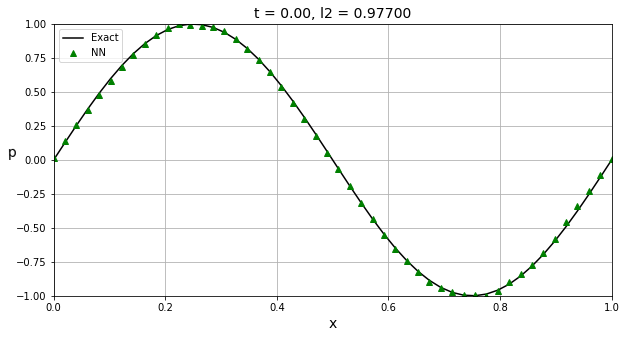

In [ ]:
# evaluate the solution
pde.load_state_dict('best_solution.pth')
x = np.linspace(0,1,50)
t = np.linspace(0,1,100)
p, p0, l2 = [], [], []
for _t in t:
    _p0 = np.sin(2.*math.pi*(x-u*_t))
    _p = pde.eval({'x': x, 't': np.array([_t])}, device)
    _l2 = np.mean((_p - _p0)**2)
    p.append(_p)
    p0.append(_p0)
    l2.append(_l2)
    
from matplotlib import animation, rc
rc('animation', html='html5')

def plot(x, p, p0, t, l2):
    ax.clear()
    tit = ax.set_title(f"t = {t:.2f}, l2 = {l2:.5f}", fontsize=14)
    ax.plot(x, p0, "-k", label="Exact")
    ax.plot(x, p, "g^", label="NN")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("p", fontsize=14, rotation=np.pi/2)
    ax.legend(loc="upper left")
    ax.grid(True)
    ax.set_xlim([0, 1])
    ax.set_ylim([-1, 1])
    return [tit]

def get_anim(fig, ax, x, p, p0, t, l2):
    def anim(i):
        return plot(x, p[i], p0[i], t[i], l2[i])
    return anim

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, autoscale_on=False)
animate = get_anim(fig, ax, x, p, p0, t, l2)
anim = animation.FuncAnimation(fig, animate, frames=len(t), interval=100, blit=True)

In [ ]:
anim

## Copyright

Copyright 2020 onwards, SensioAI. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this project's files except in compliance with the License. A copy of the License is provided in the LICENSE file in this repository.